**Анализ пользовательского поведения в мобильном приложении**

## Описание проекта

**Контекст**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

## Описание данных
Каждая запись в логе — это действие пользователя, или событие. 
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Цель исследования

С помощью A/A/B теста выяснить, влияет ли изменение шрифтов в приложении на воронку продаж и решить стоит ли использовать новый шрифт.

## План исследования

- Шаг 1. Загрузить данные и изучить общую информацию
- Шаг 2. Подготовить данные
- Шаг 3. Исследовательский анализ
- Шаг 4. Изучить воронку событий
- Шаг 5. Изучить результаты эксперимента


### Шаг 1. Загрузка и ознакомление с данными

In [56]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from datetime import datetime, timedelta
import math
from plotly import graph_objects as go
from statsmodels.sandbox.stats.multicomp import multipletests

In [57]:
# загрузка данных
data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [58]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [59]:
# посмотрим общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Шаг 2. Предобработка

In [60]:
# переименуем колонки для удобства, а также приведем к единому стилю
data.columns = ['event_name', 'device_id', 'event_timestamp', 'group_id']

In [61]:
# проверим наличие пропусков
data.isna().mean()

event_name         0.0
device_id          0.0
event_timestamp    0.0
group_id           0.0
dtype: float64

In [62]:
# проверим наличие дубликатов
data.duplicated().sum()

413

В датафрейме 413 явных (полных) дубликатов.

In [63]:
# удалим полные дубликаты из данных
data = data.drop_duplicates().reset_index(drop=True)

In [64]:
# добавим новые колонки с датами и соответсвующими типами данных
data['event_datetime'] = pd.to_datetime(data['event_timestamp'], unit = 's')
data['event_date'] = data['event_datetime'].dt.date
data['event_date'] = data['event_date'].astype('datetime64[D]')

In [65]:
# посмотрим на датафрейм после предобработки
data.head()

,event_name,device_id,event_timestamp,group_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [66]:
# посмотрим за какой период представлены данные
display(data.event_date.min())
display(data.event_date.max())

Timestamp('2019-07-25 00:00:00')

Timestamp('2019-08-07 00:00:00')

В ходе предобработки была проведена проверка на пропуски, были удалены явные дубликаты, добавлены колонки с датами. Данные готовы к анализу.

### Шаг 3. Исследовательский анализ

In [67]:
# посмотрим какие события существуют
data.event_name.unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [68]:
data.shape

(243713, 6)

Всего в логе 243713 события 5 видов:
- MainScreenAppear - главный экран
- Tutorial - страница руководства/инструкций
- OffersScreenAppear - экран товаров
- CartScreenAppear - корзина
- PaymentScreenSuccessful - экран оплаты

In [69]:
# посмотрим количество пользователей, заходивших в приложение за исследуемый период
data.device_id.nunique()

7551

За исследуемые период приложением пользовались 7551 пользователей.

In [70]:
# среднее количество событий на пользователя
data.shape[0] / data.device_id.nunique()

32.27559263673685

Таким образом, в среднем на пользователя приходится 32 события

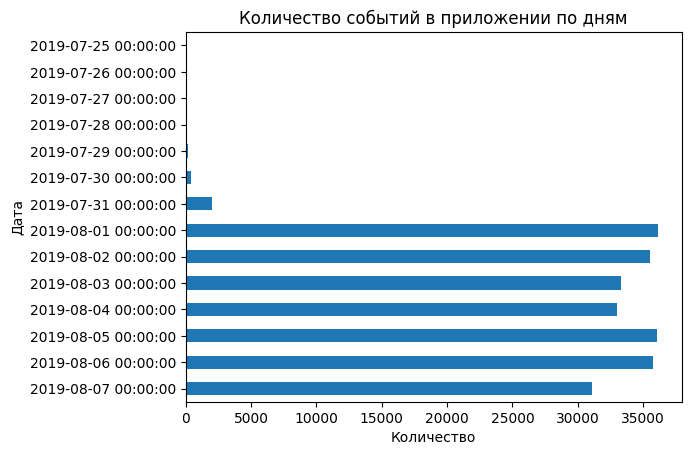

In [71]:
# изучим количество событий/действий, совершаемых пользователями по дням
data.groupby('event_date').agg({'event_name': 'count'}).sort_values('event_date', ascending=False).plot(kind='barh', legend=False)
plt.title('Количество событий в приложении по дням')
plt.xlabel('Количество')
plt.ylabel('Дата');

В логе представлены данные за период с 25.07.2019 по 07.08.2019, т.е. за 2 недели, однако на графике видно, что за первую неделю данные неполные. Придется удалить их, чтобы не искажать результаты исследования. Таким образом в нашем распоряжении останутся данные только за период с 01.08.2019 по 07.08.2019

In [72]:
# посчитаем количество событий и пользователей, которые предстоит удалить
print('Всего событий за период неполных данных: {}'.format(len( data[data['event_date'] < '2019-08-01']) ))
print('Их доля от общего количества: {0:.2f}'.format(len( data[data['event_date'] < '2019-08-01']) / data.shape[0] ))
print('Количество пользователей за период неполных данных: {}'.format(data[data['event_date'] < '2019-08-01'].device_id.nunique()))
print('Доля таких пользователей от общего количества: {0:.2f}'.format(data[data['event_date'] < '2019-08-01'].device_id.nunique() / data.device_id.nunique()))

Всего событий за период неполных данных: 2826
Их доля от общего количества: 0.01
Количество пользователей за период неполных данных: 1451
Доля таких пользователей от общего количества: 0.19


Как видим, за указанный период доля таких событий составляет всего 1%, однако удалив их, придется потерять/урезать историю 19% пользователей.

In [73]:
# удалим из датафрейма лишние данные
data = data[data['event_date'] >= '2019-08-01'].reset_index(drop=True)

In [74]:
data.head()

,event_name,device_id,event_timestamp,group_id,event_datetime,event_date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [75]:
# посмотрим количество пользователей в каждой из групп
data.groupby('group_id').agg({'device_id':'nunique'})

,device_id
group_id,
246,2484
247,2513
248,2537


В целом можно сказать группы равные (разница в контрольных группах около 1%, с тестовой около 2%), явного перевеса нет.

In [76]:
# проверим не попали ли пользователи в разные группы
users_246 = data.query('group_id == 246')['device_id'].unique()
users_247 = data.query('group_id == 247')['device_id'].unique()
users_248 = data.query('group_id == 248')['device_id'].unique()

display(len(set(users_246).intersection(users_247)))
display(len(set(users_246).intersection(users_248)))
display(len(set(users_247).intersection(users_248)))

0

0

0

Группы содержат уникальных пользователей. Пересечений нет.

### Шаг 4. Воронка продаж

In [77]:
# посмотрим сколько раз были совершены события
total_events = (
    data.groupby('event_name')
        .agg({'device_id':'count'})
        .rename(columns={'device_id':'total_events'})
        .sort_values('total_events', ascending=False)
)

total_events

,total_events
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


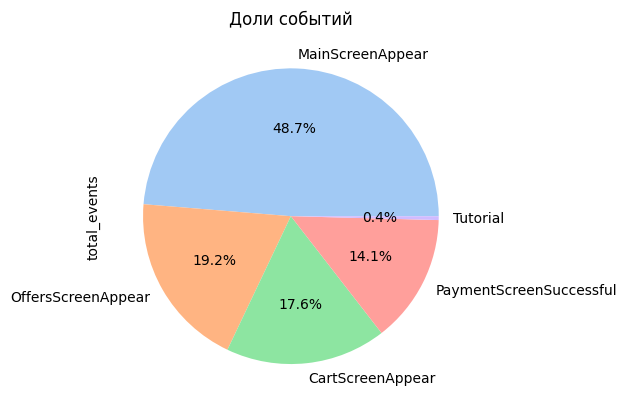

In [78]:
# построим круговую диаграмму
total_events['total_events'].plot(kind='pie', colors = sns.color_palette('pastel'), autopct='%.1f%%')
plt.title('Доли событий');

In [79]:
# посчитаем количество уникальных пользователей для каждого события и их доли
total_users = (
    data.groupby('event_name')
        .agg({'device_id':'nunique'})
        .rename(columns={'device_id':'unique_users'})
        .sort_values('unique_users', ascending=False)
)

total_users['ratio'] = round(total_users['unique_users'] / data['device_id'].nunique(), 3)

In [80]:
total_users

,unique_users,ratio
event_name,,
MainScreenAppear,7419,0.985
OffersScreenAppear,4593,0.610
CartScreenAppear,3734,0.496
PaymentScreenSuccessful,3539,0.470
Tutorial,840,0.111


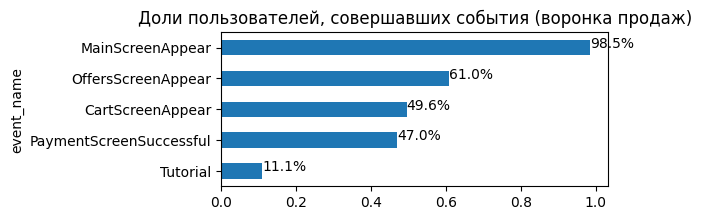

In [81]:
# посмотрим на графике полученные доли в %
total_users['ratio'].sort_values().plot(kind='barh', figsize=(5,2))
for index, value in enumerate(reversed(total_users.ratio)):
    plt.text(value, index, f'{value*100}%')
plt.title('Доли пользователей, совершавших события (воронка продаж)');

__Структура воронки. Порядок событий и доля пользователей, совершивших их.__
1. Главный экран - на графике видим, что почти все пользователи (98.5%) зашли в приложение и увидели главный экран.
2. Экран с товарами - 61% пользователей смотрели каталог
3. Корзина - половина пользователей (49.6%) перешли в корзину
4. Экран оплаты - 47% успешно завершили покупку

Также 11% пользователей попали на экран руководства/инструкций - данное событие не является ключевым шагом воронки, на экран с руководством пользователи могут попадать по разным причинам на любом этапе. Далее при анализе не будем его учитывать.

In [82]:
# уберем из таблицы данные о заходах на страницу tutorial
total_funnel = total_users.query('index != "Tutorial"').copy()

In [83]:
# посчитаем значения конверсии в шаг (какая часть пользователей переходит на следующий этап относительно предыдущего)
step_conv = [total_funnel.ratio[0]]
for i in range(1, len(total_funnel)):
    step_conv.append(round(total_funnel.unique_users[i] / total_funnel.unique_users[i - 1], 3))

total_funnel['step_conversion'] = step_conv

In [84]:
total_funnel

,unique_users,ratio,step_conversion
event_name,,,
MainScreenAppear,7419,0.985,0.985
OffersScreenAppear,4593,0.610,0.619
CartScreenAppear,3734,0.496,0.813
PaymentScreenSuccessful,3539,0.470,0.948


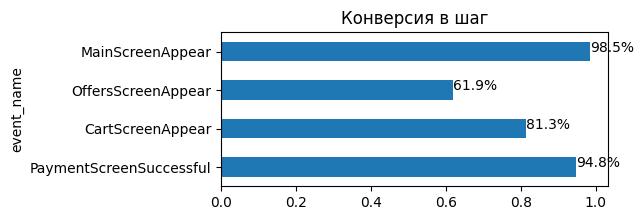

In [85]:
# посмотрим на графике конверсию в шаг
total_funnel.sort_values('unique_users')['step_conversion'].plot(kind='barh', figsize=(5,2))
for index, value in enumerate(reversed(total_funnel.step_conversion)):
    plt.text(value, index, f'{value*100}%')
plt.title('Конверсия в шаг');

На графике видим, что наибольшая доля пользователей (38.1%) теряется на переходе с главного экрана к экрану товаров, т.е. они не попадают в каталог.

Далее ситуация лучше - с экрана товаров в корзину переходят 81.3% пользователей - примерно 4 из 5 клиентов находят необходимый товар.

94.8% из них совершают покупку, т.е. более 5% пользователей отсеиваются на финальной стадии.

In [86]:
total_funnel.unique_users[3] / total_funnel.unique_users[0]

0.47701846610055265

Всего покупку совершают 47.7% пользователей.

### Шаг 5. Изучите результаты эксперимента

На стадии исследовательского анализа мы проверяли численность групп и выяснили, что они примерно равные по численности, при этом пользователей, попавших в разные группы, нет.

__A/A тест__

Есть 2 контрольные группы (246 и 247), а также тестовая (248) - пользователи, которые имели дело с приложением с измененным шрифтом. Перед проведением полноценного A/B теста необходимо провести A/A эксперимент и убедиться, что контрольные группы консистентны.

Агрегируем данные по каждой группе в единый датафрейм. Добавим информацию о количестве пользователей на каждом этапе и значения долей. Доли пользователей, перешедших на страницу руководства (событие `Tutorial`), анализировать не будем.

In [87]:
# напишем функцию для расчета
def get_aab_data(data):
    # рассчитаем размеры групп
    aab_data = (
        data.groupby('group_id')
            .agg({'device_id':'nunique'})
            .rename(columns={'device_id':'total_users'})
            .reset_index()
    )
    
    # посчитаем количество пользователей для каждого события и добавим данные в датафрейм
    for event in ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
        aab_data = (
            aab_data.merge(
                data.query('event_name == @event').groupby('group_id')
                                                .agg({'device_id':'nunique'})
                                                .rename(columns={'device_id':event}), how='left', on='group_id')
        )
    # транспонируем таблицу и переименуем колонки
    aab_data = aab_data.set_index('group_id').T
    aab_data.columns = ['246_control', '247_control', '248_test']

    # объединим данные контрольных групп для получения комбинированной выборки
    aab_data['control_combined'] = aab_data['246_control'] + aab_data['247_control']

    # посчитаем значения конверсии для каждой группы и добавим в общий датафрейм
    for group in aab_data.columns:
        conversion = [1]
        for i in range(1, len(aab_data)):
            conversion.append(round(aab_data[group][i] / aab_data[group][0], 3))
        aab_data[group+'_conversion'] = conversion
    
    aab_data = aab_data.reset_index().rename(columns={'index':'event_name'})
    
    return aab_data

In [88]:
# применим функцию и посмотрим результаты
aab_data = get_aab_data(data)

In [89]:
aab_data

,event_name,246_control,247_control,248_test,control_combined,246_control_conversion,247_control_conversion,248_test_conversion,control_combined_conversion
0,total_users,2484,2513,2537,4997,1.000,1.000,1.000,1.000
1,MainScreenAppear,2450,2476,2493,4926,0.986,0.985,0.983,0.986
2,OffersScreenAppear,1542,1520,1531,3062,0.621,0.605,0.603,0.613
3,CartScreenAppear,1266,1238,1230,2504,0.510,0.493,0.485,0.501
4,PaymentScreenSuccessful,1200,1158,1181,2358,0.483,0.461,0.466,0.472


Теперь у нас есть все необходимые данные для анализа: количество уникальных пользователей по группам для каждого события, а также их доля для каждого события (конверсия). Посмотрим данные всех групп на графике

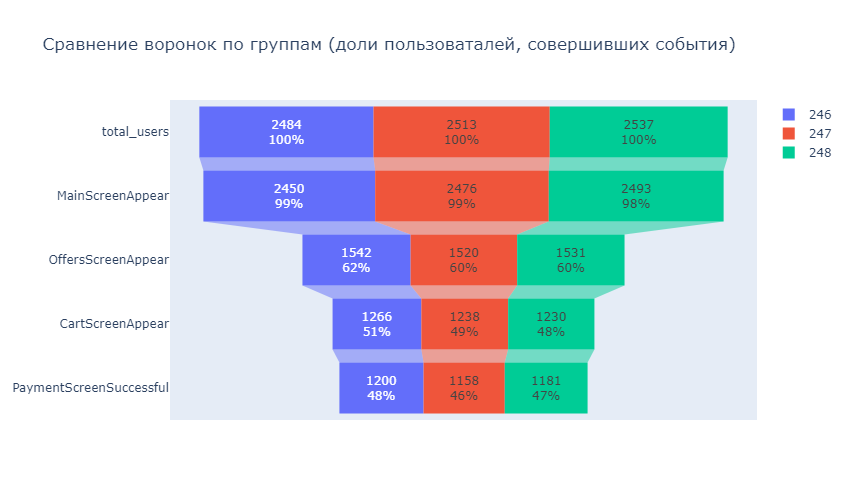

In [90]:
# отобразим воронки всех исследуемых групп на одном графике для наглядного сравнения
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = aab_data.event_name,
    x = aab_data['246_control'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = aab_data.event_name,
    x = aab_data['247_control'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = aab_data.event_name,
    x = aab_data['248_test'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(title="Сравнение воронок по группам (доли пользоваталей, совершивших события)")
fig.show(renderer='png', width=850, height=500, scale=None);

В целом явных различий, перевесов в сторону какой-либо группы нет. Наблюдаются лишь небольшие расхождения в 1-2% - необходимо проверить являются ли эти различия статистически значимыми.

Для начала сравним между собой контрольные группы (проведем A/A тест). Количество наблюдений достаточное, поэтому для сравнения пропорций в двух группах выберем параметрический критерий Z-тест, с помощью которого сравним разницу в долях и определим, является ли различие статистически значимым.

Сформулируем гипотезы для A/A эксперимента:
- Нулевая гипотеза H0 - разницы в значении конверсии между контрольными группами нет.
- Альтернативная гипотеза H1 - конверсия в группах отличается (двухсторонняя гипотеза)

In [91]:
# напишем функцию для сравнения 2 выборок с помощью Z-теста, принимающую значения количества пользователей для разных событий
# а также уровень alpha (по умолчанию поставим 0.05)
def z_test(column_1, column_2, alpha=0.05):
    for i in range(1, len(column_1)):
        
        # p1 и p2 - конверсии для события в сравниваемых группах
        p1 = column_1[i] / column_1[0]
        p2 = column_2[i] / column_2[0]
        
        # конверсия комбинированной выборки
        p_combined = (column_1[i] + column_2[i]) / (column_1[0] + column_2[0])
        
        # разница пропорций в выборках
        difference = p1 - p2
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = (
            difference /
            math.sqrt(p_combined * (1 - p_combined) * (1 / column_1[0] + 1 / column_2[0]))
        )
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        
        # задаем alpha (по умолчанию 0.05)
        alpha = alpha
        
        # считаем p-value
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        # формируем выводы
        try:
            print('Доли пользователей, совершивших событие {}'.format(aab_data['event_name'][i]))
        except:
            print(f'Доли пользователей, перешедших на {i} шаг')
            
        print(f'конверсия 1-й группы {p1}, конверсия 2-й группы {p2}')
        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Недостаточно оснований отвергнуть нулевую гипотезу, т.е. считать доли разными'
            )
        print('---------')

Применим Z-тест для двух контрольных выборок для конверсии на каждом шаге (для каждого события)

In [92]:
# применим z-тест с помощью функции для контрольных выборок
z_test(aab_data['246_control'], aab_data['247_control'])

Доли пользователей, совершивших событие MainScreenAppear
конверсия 1-й группы 0.9863123993558777, конверсия 2-й группы 0.9852765618782332
p-значение:  0.7570597232046099
Недостаточно оснований отвергнуть нулевую гипотезу, т.е. считать доли разными
---------
Доли пользователей, совершивших событие OffersScreenAppear
конверсия 1-й группы 0.6207729468599034, конверсия 2-й группы 0.6048547552725826
p-значение:  0.2480954578522181
Недостаточно оснований отвергнуть нулевую гипотезу, т.е. считать доли разными
---------
Доли пользователей, совершивших событие CartScreenAppear
конверсия 1-й группы 0.5096618357487923, конверсия 2-й группы 0.4926382809391166
p-значение:  0.22883372237997213
Недостаточно оснований отвергнуть нулевую гипотезу, т.е. считать доли разными
---------
Доли пользователей, совершивших событие PaymentScreenSuccessful
конверсия 1-й группы 0.4830917874396135, конверсия 2-й группы 0.46080382013529647
p-значение:  0.11456679313141849
Недостаточно оснований отвергнуть нулевую ги

Таким образом между значениями конверсии выборок 246 и 247 нет статистически значимых различий, а разница в значении общей конверсии 2.2% получена случайно, т.е. H0 верна, группы консистентны, значит можем проводить A/A/B тест и анализировать результаты тестовой группы.

__A/A/B тест__

Гипотезы для A/A/B эксперимента:
- Нулевая гипотеза H0 - конверсия пользователей в тестовой группе не отличается от показателей пользователей контрольных групп;
- Альтернативная гипотеза H1 - значения конверсии в тестовой и контрольных группах различны.

Поскольку в нашем A/A/B тесте участвуют сразу несколько групп, каждую из которых мы сравниваем сразу по 4 пропорциям (значениям конверсии на каждом шаге воронки), необходимо применить поправку, используемую при множественной проверке гипотез. В нашем случае суммарно проверяется 16 гипотез, что не позволяет использовать поправку Бонферрони из-за сильного снижения уровня alpha и уменьшения мощности теста. Таким образом применим поправку Шидака-Холма, для чего обновим функцию, с помощью которой соберем все необходимые уровни p-value для каждой пары, после чего объединим их в один список, скорректируем их значения и посмотрим результаты.

In [93]:
# обновим функцию, теперь она будет возвращать список Значений p-value
def get_pvalue_z_test(column_1, column_2, alpha=0.05):
    pvalues = []
    for i in range(1, len(column_1)):
        
        # p1 и p2 - конверсии для события в сравниваемых группах
        p1 = column_1[i] / column_1[0]
        p2 = column_2[i] / column_2[0]
        
        # конверсия комбинированной выборки
        p_combined = (column_1[i] + column_2[i]) / (column_1[0] + column_2[0])
        
        # разница пропорций в выборках
        difference = p1 - p2
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = (
            difference /
            math.sqrt(p_combined * (1 - p_combined) * (1 / column_1[0] + 1 / column_2[0]))
        )
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        
        # задаем alpha (по умолчанию 0.05)
        alpha = alpha
        
        # считаем p-value
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        pvalues.append(p_value)
        
    return pvalues

In [94]:
# применим функцию - проведем все необходимые сравнения и получим списки значений p-value для каждой пары
pvalues_246_247 = get_pvalue_z_test(aab_data['246_control'], aab_data['247_control'])
pvalues_246_248 = get_pvalue_z_test(aab_data['246_control'], aab_data['248_test'])
pvalues_247_248 = get_pvalue_z_test(aab_data['247_control'], aab_data['248_test'])
pvalues_248_combined = get_pvalue_z_test(aab_data['248_test'], aab_data['control_combined'])

# общий список
all_pvalues = pvalues_246_247 + pvalues_246_248 + pvalues_247_248 + pvalues_248_combined

In [95]:
# применим поправку Шидака-Холма из библиотеки statsmodels 
multipletests(all_pvalues, method='holm-sidak', alpha=0.05)

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]),
 array([0.98671472, 0.95204368, 0.95204368, 0.83881038, 0.95656056,
        0.95204368, 0.72931821, 0.95204368, 0.98145006, 0.98671472,
        0.98671472, 0.98671472, 0.95656056, 0.98145006, 0.93969697,
        0.98671472]),
 0.0032006977101884937,
 0.003125)

Таким образом, в ходе множественной проверки гипотез у нас нет оснований полагать, что между группами есть статистически значимые различия.

## Результаты и общие выводы:

1. В рамках исследования были загружены и подготовлены к анализу данные о действиях пользователей мобильного приложения за период с 25.07.2019 по 07.08.2019.
2. На стадии предобработки были удалены явные дубликаты, а также информация о событиях за те дни, когда данные оказались неполными - около 1% от общего количества логов. Полноценный анализ проводился за период с 01.08.2019 по 07.08.2019 на основе данных о 7534 пользователях, разделенных на 3 группы - 2 контрольные (246 и 247) и 1 тестовая (248).
3. Была проанализирована общая воронка продаж - порядок событий и доли пользователей, которые их совершили. Мы выяснили, что:
    * почти все пользователи (98.5%) зашли в приложение и увидели главный экран;
    * на экран с товарами (каталог) зашли - 61% пользователей, т.е. 38% пользователей отсеиваются после просмотра главного экрана - следует обратить внимание на данный показатель, вероятно есть какие-то проблемы с интерфейсом;
    * около половины пользователей (49.6%) перешли в корзину, значит нашли интересующий товар;
    * 47% пользователей успешно завершили покупку;
    * еще около 11% пользователей заходили на экран руководства/инструкций. Данное событие не является ключевым в воронке.
4. Также был проведен A/A/B тест. За указанный период пользователи тестовой группы взаимодействовали с приложением, в котором дизайнеры изменили шрифт, а пользователи двух контрольных групп совершали покупки без изменений дизайна. С помощью Z-теста было выяснено, что при заданном уровне alpha=0.05 (при множественном сравнении применялась поправка, а уровень FWER=0.05) статистически значимых различий между тестовой и контрольными группами нет. Это означает, что экономического смысла в изменении шрифтов и дизайна приложения нет, однако если инициатива дизайнеров связана с какими-либо иными факторами, например изменением фирменного стиля и т.д., то результаты эксперимента показывают, что препятствий нет - можно менять шрифт и это не отразится на уровне продаж.
